In [169]:
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sys
sys.path.append( 'D:\\python\\miniconda\\lib\\site-packages')
from IPython.core.interactiveshell import InteractiveShell 

# Show every run result
InteractiveShell.ast_node_interactivity = 'all'

# MODEL PREPARATION

In [170]:
from pandas_datareader.famafrench import get_available_datasets
import pandas_datareader.data as web
ff_dict = web.DataReader('F-F_Research_Data_Factors_daily', 'famafrench', 
                         start='2012-01-01')
print(ff_dict['DESCR'])
ff_3_daily = ff_dict[0]

F-F Research Data Factors daily
-------------------------------

This file was created by CMPT_ME_BEME_RETS_DAILY using the 202307 CRSP database. The Tbill return is the simple daily rate that, over the number of trading days in the month, compounds to 1-month TBill rate from Ibbotson and Associates Inc. Copyright 2023 Kenneth R. French

  0 : (2912 rows x 4 cols)


In [171]:
factor_df = ff_3_daily.apply(pd.to_numeric, 
                             errors='coerce') \
                            .div(100)
factor_df.index = factor_df.index.strftime('%Y-%m-%d')
factor_df.columns = ['mkt', 'smb', 'hml', 'rf']
factor_df.head()

,mkt,smb,hml,rf
Date,,,,
2012-01-03,0.0150,-0.0018,0.0092,0.0
2012-01-04,0.0000,-0.0065,0.0003,0.0
2012-01-05,0.0039,0.0018,0.0019,0.0
2012-01-06,-0.0019,0.0002,-0.0027,0.0
2012-01-09,0.0028,0.0023,-0.0006,0.0


# DATA PREPARATION

In [172]:
RISKY_ASSET = ["^GSPC", "^IXIC", "^DJI", "^NYA"]
START_DATE = '2012-01-01'
END_DATE = '2023-09-01'

In [175]:
asset_df = yf.download(RISKY_ASSET,
                       start=START_DATE,
                       end=END_DATE,
                       auto_adjust=True,
                       progress=False)

print(f'Downloaded {asset_df.shape[0]} rows of data.')

Downloaded 2935 rows of data.


In [176]:
y = asset_df['Close'].pct_change() \
                     .dropna()\
                     .apply(pd.to_numeric, 
                            errors='coerce')

y.index = y.index.strftime('%Y-%m-%d')
y.name = 'rtn'
y.head()

,^DJI,^GSPC,^IXIC,^NYA
Date,,,,
2012-01-04,0.001697,0.000188,-0.000136,-0.001596
2012-01-05,-0.000219,0.002944,0.008118,-0.001600
2012-01-06,-0.004493,-0.002537,0.001633,-0.005565
2012-01-09,0.002651,0.002262,0.000875,0.003570
2012-01-10,0.005631,0.008886,0.009692,0.011107


In [177]:
ff_data = factor_df.join(y)
ff_data.dropna()

,mkt,smb,hml,rf,^DJI,^GSPC,^IXIC,^NYA
Date,,,,,,,,
2012-01-04,0.0000,-0.0065,0.0003,0.00000,0.001697,0.000188,-0.000136,-0.001596
2012-01-05,0.0039,0.0018,0.0019,0.00000,-0.000219,0.002944,0.008118,-0.001600
2012-01-06,-0.0019,0.0002,-0.0027,0.00000,-0.004493,-0.002537,0.001633,-0.005565
2012-01-09,0.0028,0.0023,-0.0006,0.00000,0.002651,0.002262,0.000875,0.003570
2012-01-10,0.0097,0.0037,0.0038,0.00000,0.005631,0.008886,0.009692,0.011107
...,...,...,...,...,...,...,...,...
2023-07-25,0.0025,-0.0004,-0.0079,0.00022,0.000758,0.002815,0.006095,0.000979
2023-07-26,0.0002,0.0068,0.0103,0.00022,0.002315,-0.000155,-0.001222,0.002017
2023-07-27,-0.0074,-0.0090,0.0027,0.00022,-0.006684,-0.006425,-0.005462,-0.008991


In [178]:
# 去掉列名中的'^'字符
ff_data.columns = [str(col).replace("^", "") for col in ff_data.columns]
ff_data.dropna()

,mkt,smb,hml,rf,DJI,GSPC,IXIC,NYA
Date,,,,,,,,
2012-01-04,0.0000,-0.0065,0.0003,0.00000,0.001697,0.000188,-0.000136,-0.001596
2012-01-05,0.0039,0.0018,0.0019,0.00000,-0.000219,0.002944,0.008118,-0.001600
2012-01-06,-0.0019,0.0002,-0.0027,0.00000,-0.004493,-0.002537,0.001633,-0.005565
2012-01-09,0.0028,0.0023,-0.0006,0.00000,0.002651,0.002262,0.000875,0.003570
2012-01-10,0.0097,0.0037,0.0038,0.00000,0.005631,0.008886,0.009692,0.011107
...,...,...,...,...,...,...,...,...
2023-07-25,0.0025,-0.0004,-0.0079,0.00022,0.000758,0.002815,0.006095,0.000979
2023-07-26,0.0002,0.0068,0.0103,0.00022,0.002315,-0.000155,-0.001222,0.002017
2023-07-27,-0.0074,-0.0090,0.0027,0.00022,-0.006684,-0.006425,-0.005462,-0.008991


In [179]:
ff_data

,mkt,smb,hml,rf,DJI,GSPC,IXIC,NYA
Date,,,,,,,,
2012-01-03,0.0150,-0.0018,0.0092,0.00000,NaN,NaN,NaN,NaN
2012-01-04,0.0000,-0.0065,0.0003,0.00000,0.001697,0.000188,-0.000136,-0.001596
2012-01-05,0.0039,0.0018,0.0019,0.00000,-0.000219,0.002944,0.008118,-0.001600
2012-01-06,-0.0019,0.0002,-0.0027,0.00000,-0.004493,-0.002537,0.001633,-0.005565
2012-01-09,0.0028,0.0023,-0.0006,0.00000,0.002651,0.002262,0.000875,0.003570
...,...,...,...,...,...,...,...,...
2023-07-25,0.0025,-0.0004,-0.0079,0.00022,0.000758,0.002815,0.006095,0.000979
2023-07-26,0.0002,0.0068,0.0103,0.00022,0.002315,-0.000155,-0.001222,0.002017
2023-07-27,-0.0074,-0.0090,0.0027,0.00022,-0.006684,-0.006425,-0.005462,-0.008991



GSPC 模型摘要:
                            OLS Regression Results                            
Dep. Variable:        excess_rtn_GSPC   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 2.979e+05
Date:                Tue, 19 Sep 2023   Prob (F-statistic):               0.00
Time:                        20:39:14   Log-Likelihood:                 17408.
No. Observations:                2911   AIC:                        -3.481e+04
Df Residuals:                    2907   BIC:                        -3.479e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -6.794e-05   1.14e-05     -5.

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, '预期回报 GSPC')

Text(0.5, 0, '日期')

Text(0, 0.5, '年化预期回报')


IXIC 模型摘要:
                            OLS Regression Results                            
Dep. Variable:        excess_rtn_IXIC   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                 2.801e+04
Date:                Tue, 19 Sep 2023   Prob (F-statistic):               0.00
Time:                        20:39:17   Log-Likelihood:                 13530.
No. Observations:                2911   AIC:                        -2.705e+04
Df Residuals:                    2907   BIC:                        -2.703e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.923e-05   4.31e-05      0.

/var/folders/p8/lt1hpjbj0gv7cp_kv649f8sc0000gn/T/ipykernel_34498/1349840904.py:23: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.tight_layout()
/var/folders/p8/lt1hpjbj0gv7cp_kv649f8sc0000gn/T/ipykernel_34498/1349840904.py:23: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.tight_layout()
/var/folders/p8/lt1hpjbj0gv7cp_kv649f8sc0000gn/T/ipykernel_34498/1349840904.py:23: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  plt.tight_layout()
/var/folders/p8/lt1hpjbj0gv7cp_kv649f8sc0000gn/T/ipykernel_34498/1349840904.py:23: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from current font.
  plt.tight_layout()
/var/folders/p8/lt1hpjbj0gv7cp_kv649f8sc0000gn/T/ipykernel_34498/1349840904.py:23: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  plt.tight_layout()
/var/folders/p8/lt1hpjbj0gv7cp_kv649f8sc0000gn/T/ipyker

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, '预期回报 IXIC')

Text(0.5, 0, '日期')

Text(0, 0.5, '年化预期回报')


DJI 模型摘要:
                            OLS Regression Results                            
Dep. Variable:         excess_rtn_DJI   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.942
Method:                 Least Squares   F-statistic:                 1.585e+04
Date:                Tue, 19 Sep 2023   Prob (F-statistic):               0.00
Time:                        20:39:20   Log-Likelihood:                 13267.
No. Observations:                2911   AIC:                        -2.653e+04
Df Residuals:                    2907   BIC:                        -2.650e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0001   4.71e-05     -2.4

/var/folders/p8/lt1hpjbj0gv7cp_kv649f8sc0000gn/T/ipykernel_34498/1349840904.py:23: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.tight_layout()
/var/folders/p8/lt1hpjbj0gv7cp_kv649f8sc0000gn/T/ipykernel_34498/1349840904.py:23: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.tight_layout()
/var/folders/p8/lt1hpjbj0gv7cp_kv649f8sc0000gn/T/ipykernel_34498/1349840904.py:23: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  plt.tight_layout()
/var/folders/p8/lt1hpjbj0gv7cp_kv649f8sc0000gn/T/ipykernel_34498/1349840904.py:23: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from current font.
  plt.tight_layout()
/var/folders/p8/lt1hpjbj0gv7cp_kv649f8sc0000gn/T/ipykernel_34498/1349840904.py:23: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  plt.tight_layout()
/var/folders/p8/lt1hpjbj0gv7cp_kv649f8sc0000gn/T/ipyker

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, '预期回报 DJI')

Text(0.5, 0, '日期')

Text(0, 0.5, '年化预期回报')


NYA 模型摘要:
                            OLS Regression Results                            
Dep. Variable:         excess_rtn_NYA   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                 2.398e+04
Date:                Tue, 19 Sep 2023   Prob (F-statistic):               0.00
Time:                        20:39:27   Log-Likelihood:                 13893.
No. Observations:                2911   AIC:                        -2.778e+04
Df Residuals:                    2907   BIC:                        -2.775e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0002    3.8e-05     -5.1

/var/folders/p8/lt1hpjbj0gv7cp_kv649f8sc0000gn/T/ipykernel_34498/1349840904.py:23: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.tight_layout()
/var/folders/p8/lt1hpjbj0gv7cp_kv649f8sc0000gn/T/ipykernel_34498/1349840904.py:23: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.tight_layout()
/var/folders/p8/lt1hpjbj0gv7cp_kv649f8sc0000gn/T/ipykernel_34498/1349840904.py:23: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  plt.tight_layout()
/var/folders/p8/lt1hpjbj0gv7cp_kv649f8sc0000gn/T/ipykernel_34498/1349840904.py:23: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from current font.
  plt.tight_layout()
/var/folders/p8/lt1hpjbj0gv7cp_kv649f8sc0000gn/T/ipykernel_34498/1349840904.py:23: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  plt.tight_layout()
/var/folders/p8/lt1hpjbj0gv7cp_kv649f8sc0000gn/T/ipyker

<Figure size 1000x500 with 0 Axes>

Text(0.5, 1.0, '预期回报 NYA')

Text(0.5, 0, '日期')

Text(0, 0.5, '年化预期回报')

/var/folders/p8/lt1hpjbj0gv7cp_kv649f8sc0000gn/T/ipykernel_34498/1349840904.py:23: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  plt.tight_layout()
/var/folders/p8/lt1hpjbj0gv7cp_kv649f8sc0000gn/T/ipykernel_34498/1349840904.py:23: UserWarning: Glyph 26399 (\N{CJK UNIFIED IDEOGRAPH-671F}) missing from current font.
  plt.tight_layout()
/var/folders/p8/lt1hpjbj0gv7cp_kv649f8sc0000gn/T/ipykernel_34498/1349840904.py:23: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  plt.tight_layout()
/var/folders/p8/lt1hpjbj0gv7cp_kv649f8sc0000gn/T/ipykernel_34498/1349840904.py:23: UserWarning: Glyph 21270 (\N{CJK UNIFIED IDEOGRAPH-5316}) missing from current font.
  plt.tight_layout()
/var/folders/p8/lt1hpjbj0gv7cp_kv649f8sc0000gn/T/ipykernel_34498/1349840904.py:23: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from current font.
  plt.tight_layout()
/var/folders/p8/lt1hpjbj0gv7cp_kv649f8sc0000gn/T/ipyker

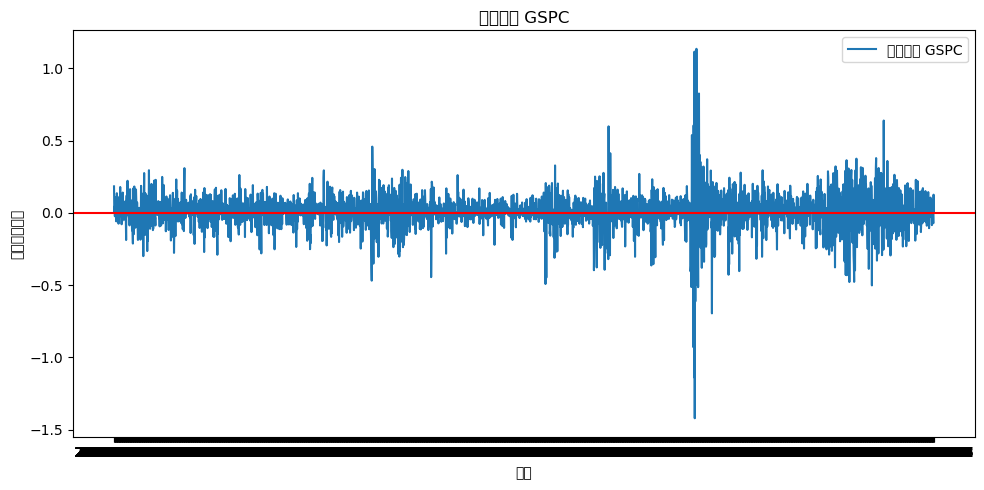

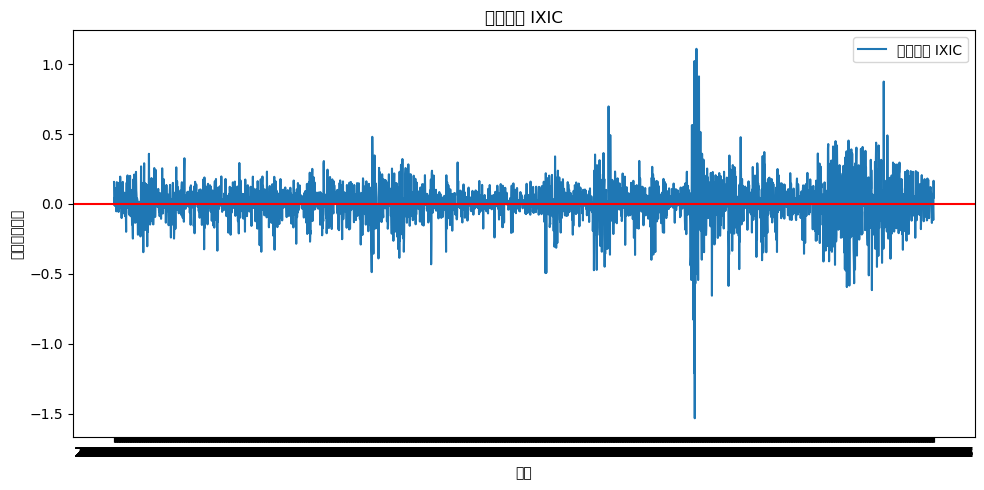

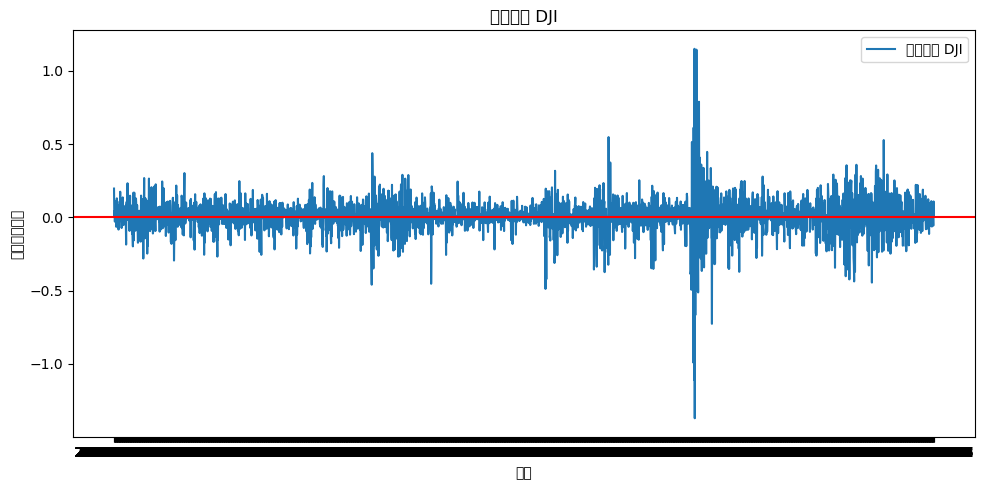

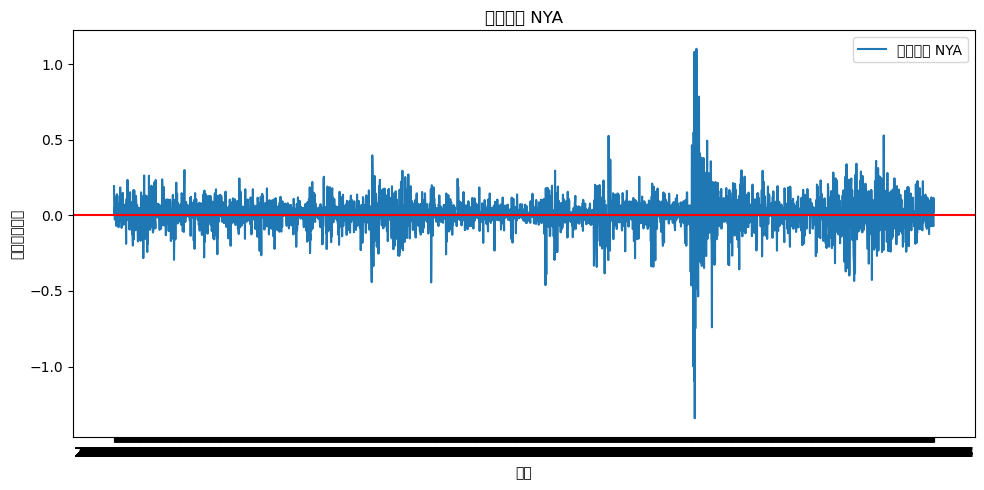

In [180]:
RISKY_ASSET_NEW = ["GSPC", "IXIC", "DJI", "NYA"]
for asset in RISKY_ASSET_NEW:
    ff_data[f'excess_rtn_{asset}'] = ff_data[asset] - ff_data['rf']
    #ff_model = smf.ols(formula='excess_rtn_{asset} ~ mkt + smb + hml', data=ff_data).fit()
    formula = f'excess_rtn_{asset} ~ mkt + smb + hml'
    ff_model = smf.ols(formula=formula, data=ff_data.dropna()).fit()
    print(f'\n{asset} 模型摘要:')
    print(ff_model.summary())

    intercept, beta_m, beta_s, beta_h = ff_model.params
    print(f'{asset} 贝塔值: {beta_m}, {beta_s}, {beta_h}')

    ff_data[f'EXPECT_RETURN_{asset}'] = (factor_df['rf'] + beta_m*(factor_df['mkt']-factor_df['rf']) + beta_s*factor_df['smb'] + beta_h*factor_df['hml']) * 12

    # 绘制预期回报
    plt.figure(figsize=(10, 5))
    plt.plot(ff_data.index, ff_data[f'EXPECT_RETURN_{asset}'], label=f'预期回报 {asset}')
    plt.title(f'预期回报 {asset}')
    plt.xlabel('日期')
    plt.ylabel('年化预期回报')
    plt.axhline(0, color='red')
    plt.legend()
    plt.tight_layout()

plt.show()

In [181]:
ff_data

,mkt,smb,hml,rf,DJI,GSPC,IXIC,NYA,excess_rtn_GSPC,EXPECT_RETURN_GSPC,excess_rtn_IXIC,EXPECT_RETURN_IXIC,excess_rtn_DJI,EXPECT_RETURN_DJI,excess_rtn_NYA,EXPECT_RETURN_NYA
Date,,,,,,,,,,,,,,,,
2012-01-03,0.0150,-0.0018,0.0092,0.00000,NaN,NaN,NaN,NaN,NaN,0.183254,NaN,0.157292,NaN,0.196776,NaN,0.193012
2012-01-04,0.0000,-0.0065,0.0003,0.00000,0.001697,0.000188,-0.000136,-0.001596,0.000188,0.010807,-0.000136,-0.006830,0.001697,0.015401,-0.001596,0.001837
2012-01-05,0.0039,0.0018,0.0019,0.00000,-0.000219,0.002944,0.008118,-0.001600,0.002944,0.043774,0.008118,0.044807,-0.000219,0.044815,-0.001600,0.048368
2012-01-06,-0.0019,0.0002,-0.0027,0.00000,-0.004493,-0.002537,0.001633,-0.005565,-0.002537,-0.023569,0.001633,-0.013892,-0.004493,-0.028716,-0.005565,-0.029096
2012-01-09,0.0028,0.0023,-0.0006,0.00000,0.002651,0.002262,0.000875,0.003570,0.002262,0.029248,0.000875,0.040795,0.002651,0.024971,0.003570,0.028628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-25,0.0025,-0.0004,-0.0079,0.00022,0.000758,0.002815,0.006095,0.000979,0.002595,0.028260,0.005875,0.063128,0.000538,0.009481,0.000759,0.003808
2023-07-26,0.0002,0.0068,0.0103,0.00022,0.002315,-0.000155,-0.001222,0.002017,-0.000375,-0.006114,-0.001442,-0.032356,0.002095,0.012960,0.001797,0.032674
2023-07-27,-0.0074,-0.0090,0.0027,0.00022,-0.006684,-0.006425,-0.005462,-0.008991,-0.006645,-0.072152,-0.005682,-0.114971,-0.006904,-0.056461,-0.009211,-0.071642


In [182]:
actual_columns = ['GSPC', 'IXIC', 'DJI', 'NYA']
predicted_columns = ['EXPECT_RETURN_GSPC', 'EXPECT_RETURN_IXIC', 'EXPECT_RETURN_DJI', 'EXPECT_RETURN_NYA']

actual_df = ff_data[actual_columns]
predicted_df = ff_data[predicted_columns]
predicted_df = predicted_df.iloc[1:]
actual_df = actual_df.iloc[1:]


In [183]:
actual_df 

,GSPC,IXIC,DJI,NYA
Date,,,,
2012-01-04,0.000188,-0.000136,0.001697,-0.001596
2012-01-05,0.002944,0.008118,-0.000219,-0.001600
2012-01-06,-0.002537,0.001633,-0.004493,-0.005565
2012-01-09,0.002262,0.000875,0.002651,0.003570
2012-01-10,0.008886,0.009692,0.005631,0.011107
...,...,...,...,...
2023-07-25,0.002815,0.006095,0.000758,0.000979
2023-07-26,-0.000155,-0.001222,0.002315,0.002017
2023-07-27,-0.006425,-0.005462,-0.006684,-0.008991


In [184]:
predicted_df

,EXPECT_RETURN_GSPC,EXPECT_RETURN_IXIC,EXPECT_RETURN_DJI,EXPECT_RETURN_NYA
Date,,,,
2012-01-04,0.010807,-0.006830,0.015401,0.001837
2012-01-05,0.043774,0.044807,0.044815,0.048368
2012-01-06,-0.023569,-0.013892,-0.028716,-0.029096
2012-01-09,0.029248,0.040795,0.024971,0.028628
2012-01-10,0.109912,0.114421,0.110889,0.117605
...,...,...,...,...
2023-07-25,0.028260,0.063128,0.009481,0.003808
2023-07-26,-0.006114,-0.032356,0.012960,0.032674
2023-07-27,-0.072152,-0.114971,-0.056461,-0.071642


In [189]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Initialize lists to store performance metrics
mae_list = []
rmse_list = []
r2_list = []
mse_list = []

# Calculate performance metrics for each stock
for asset in RISKY_ASSET_NEW:
    actual_values = actual_df[asset]
    predicted_values = predicted_df[f'EXPECT_RETURN_{asset}']
    
    # Calculate MAE
    mae = mean_absolute_error(actual_values, predicted_values)
    mae_list.append(mae)
    
    # Calculate RMSE
    rmse = mean_squared_error(actual_values, predicted_values, squared=False)
    rmse_list.append(rmse)
    
    # Calculate R-squared
    r2 = r2_score(actual_values, predicted_values)
    r2_list.append(r2)
    
    # Calculate MSE
    mse = mean_squared_error(actual_values, predicted_values)
    mse_list.append(mse)

# Create a DataFrame to store performance metrics
performance_df = pd.DataFrame({
    'Stock': RISKY_ASSET_NEW,
    'MAE': mae_list,
    'RMSE': rmse_list,
    'R-squared': r2_list,
    'MSE': mse_list
})

# Print the performance metrics DataFrame
print("Performance Metrics:")
print(performance_df)


Performance Metrics:
  Stock       MAE      RMSE   R-squared       MSE
0  GSPC  0.077471  0.118136 -119.919543  0.013956
1  IXIC  0.093155  0.137307 -116.250440  0.018853
2   DJI  0.074005  0.113049 -113.373952  0.012780
3   NYA  0.074136  0.112149 -115.628346  0.012577


<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Returns')

Text(0.5, 1.0, 'Stock Returns Prediction for GSPC')

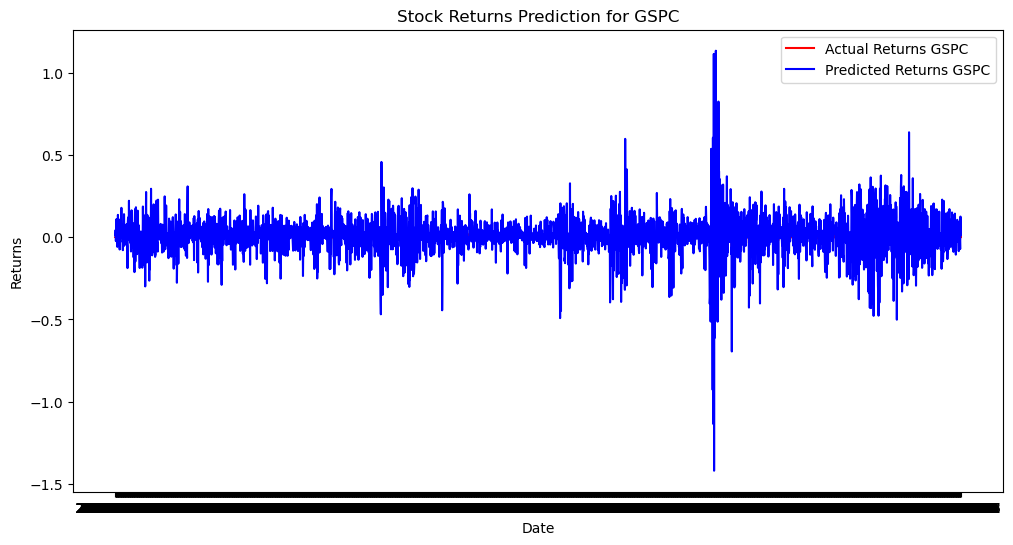

<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Returns')

Text(0.5, 1.0, 'Stock Returns Prediction for IXIC')

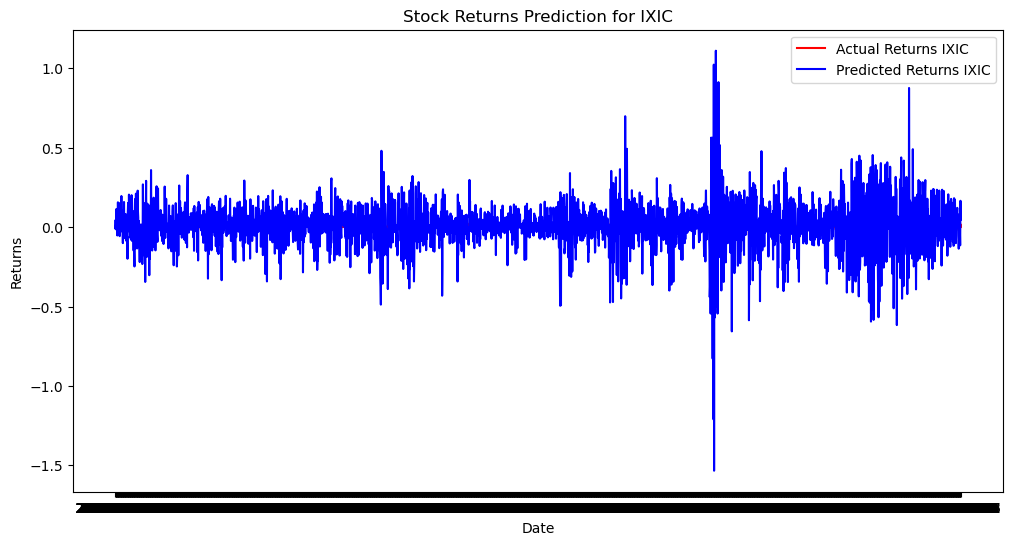

<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Returns')

Text(0.5, 1.0, 'Stock Returns Prediction for DJI')

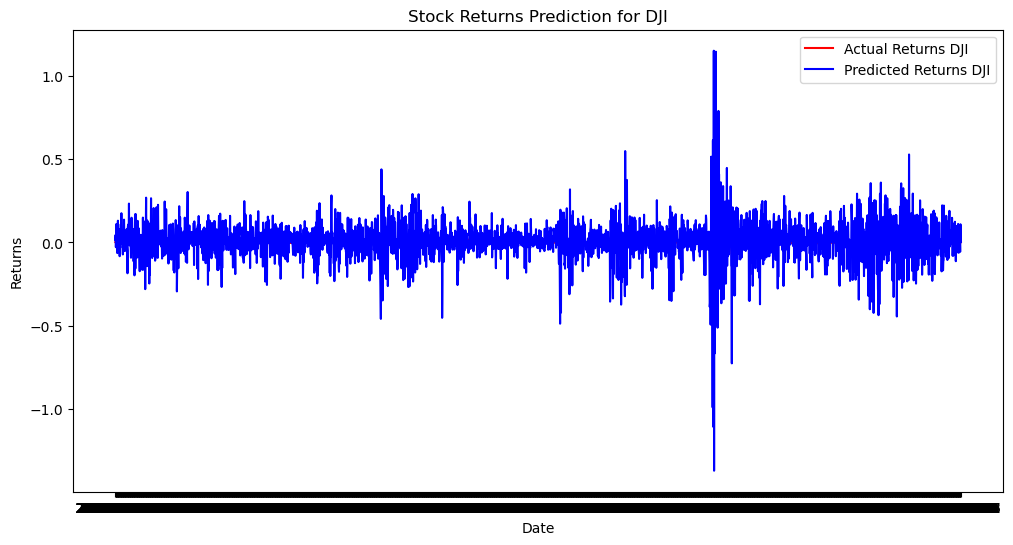

<Figure size 1200x600 with 0 Axes>

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Returns')

Text(0.5, 1.0, 'Stock Returns Prediction for NYA')

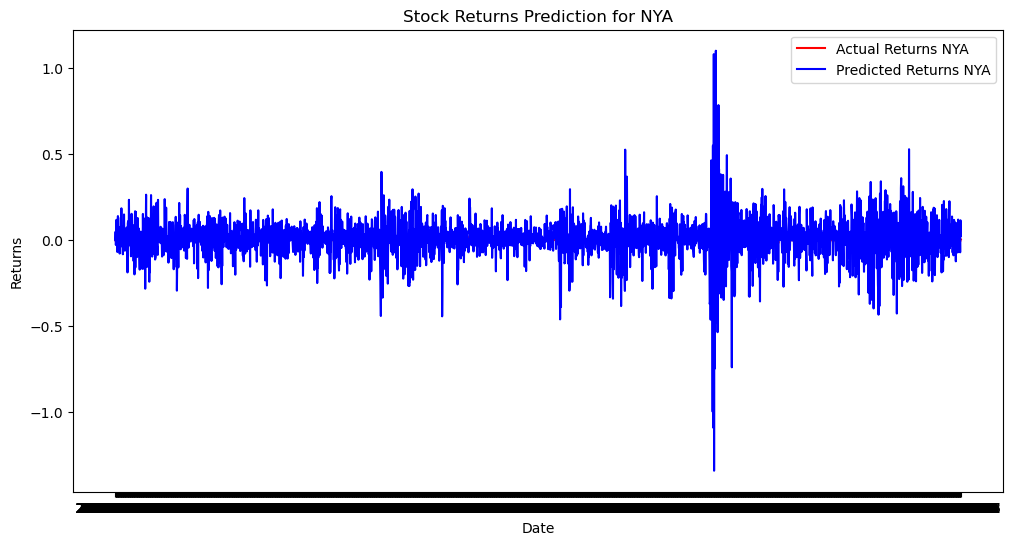

In [190]:
import matplotlib.pyplot as plt

# Iterate over each stock
for asset in RISKY_ASSET_NEW:
    actual_values = actual_df[asset]
    predicted_values = predicted_df[f'EXPECT_RETURN_{asset}']
    
    # Create a new figure for each stock
    plt.figure(figsize=(12, 6))
    
    # Plot the actual values in red
    plt.plot(actual_values.index, actual_values.values, label=f'Actual Returns {asset}', color='red')
    
    # Plot the predicted values in blue
    plt.plot(predicted_values.index, predicted_values.values, label=f'Predicted Returns {asset}', color='blue')
    
    # Add labels and title
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.title(f'Stock Returns Prediction for {asset}')
    
    # Add a legend
    plt.legend()
    
    # Show the plot
    plt.show()


# =======================================================================